**End to end Face Detection**

Before we start with the project we need to setup our environment and get the data ready which can be done as follow:
* installing all the dependencies
* collecting images

In [1]:
#getting all the dependencies 
%pip install labelme tensorflow opencv-python matplotlib albumentations

  Using cached labelme-5.5.0.tar.gz (1.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached matplotlib-3.9.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached albumentations-1.4.20-py3-none-any.whl.metadata (32 kB)
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached imgviz-1.7.5.tar.gz (7.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'


**Collecting images using OpenCV**

we will be using OpenCV to access our images and them annotate them using Label me...

In [2]:
#importing all the libraries
import os
import time
import uuid #giving our images a unique ID 
import cv2

In [6]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [10]:
#using a custom for loop to capture our images and saving them in the defined path for further analysis
cap = cv2.VideoCapture(0) #change this based on your camra input
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [12]:
#now we need to annotate our images using LabelMe
!labelme

2024-10-26 22:43:06,244 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\amirt\.labelmerc


**Bulding our image intergration function**

after capturing and annotating our images now we need to review our data and then build a function that would load them.


In [13]:
#importing our libraries:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [15]:
#loading our images:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')
images.as_numpy_iterator().next()

b'data\\images\\ea1de0b5-93e2-11ef-b7b0-98bb1e1c5484.jpg'

In [16]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [17]:
images = images.map(load_image)

In [18]:
images.as_numpy_iterator().next()

array([[[ 99,  94,  91],
        [ 98,  93,  90],
        [ 98,  93,  89],
        ...,
        [119, 123, 124],
        [122, 123, 125],
        [122, 123, 125]],

       [[ 97,  92,  89],
        [ 97,  92,  89],
        [ 97,  92,  88],
        ...,
        [120, 124, 125],
        [121, 122, 124],
        [121, 122, 124]],

       [[ 96,  91,  88],
        [ 97,  92,  89],
        [ 99,  91,  89],
        ...,
        [120, 124, 123],
        [121, 123, 122],
        [120, 122, 121]],

       ...,

       [[ 31,  29,  30],
        [ 29,  29,  29],
        [ 28,  30,  27],
        ...,
        [ 78,  78,  70],
        [ 83,  80,  71],
        [ 87,  84,  75]],

       [[ 30,  30,  30],
        [ 29,  29,  29],
        [ 28,  30,  27],
        ...,
        [ 84,  84,  76],
        [ 89,  86,  77],
        [ 91,  88,  79]],

       [[ 30,  30,  30],
        [ 28,  28,  26],
        [ 28,  30,  27],
        ...,
        [ 89,  89,  81],
        [ 93,  90,  81],
        [ 95,  92,  83]]

In [19]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

**Visualising our images**

in this section we will be using Matplotlib to visualise our raw images

which can help us to understand our data furthemore.


In [22]:
image_generator = images.batch(4).as_numpy_iterator()

In [23]:
plot_images = image_generator.next()

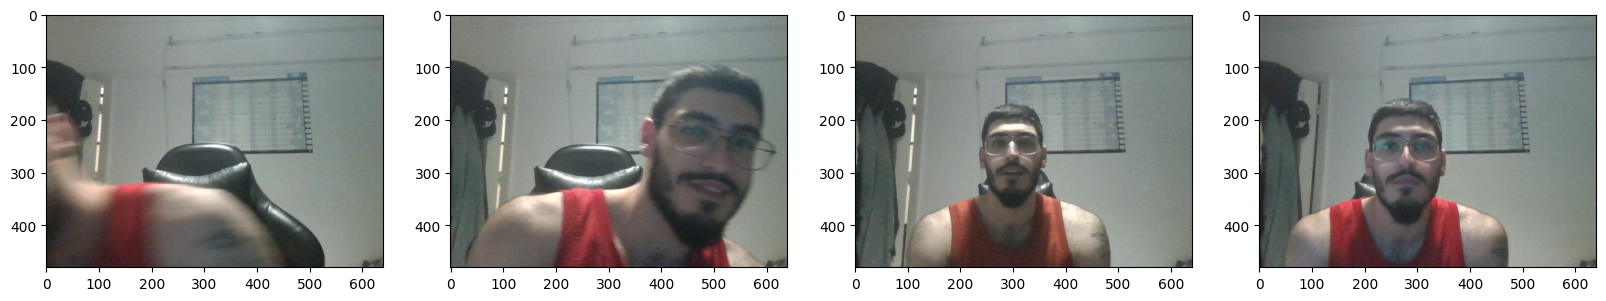

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()
#test